**GitHub Repository:** https://github.com/jperrin74/CNN-Cancer-Detection

**Problem and Dataset Description**

The purpose of this challenge is to develop an algorithm that identifies metastatic cancer within images of pathology scans. The images will be classified as either 1 (indicating an identification of metastatic tissue) or 0 (indicating a negative identification of metastatic tissue). The tumor tissue diagnosis is only based on the presence of a tumor within the 32 by 32 pixel region of each image. Creating this algorithm can assist pathologists in diagnosing cancer accurately and efficiently.

The dataset from the Kaggle competition contains a training folder with 220,000 image patches for the training of the model. Each image has its now unique identification. Within the dataset, the train_labels.csv file has an id column for each image as well as the label (0 for no metastatic tissue, 1 for metastatic tissue). The test folder contains 57,000 unlabeled images to test the algorithm. All the images in the data set are 96 by 96 pixels, with the patches of each image being 32 by 32 pixels to provide padding.

**Libraries and Data Loading**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import itertools
import tensorflow as tf 
import gc

In [2]:
# GPU Setup Check
print("--- Checking for GPU availability ---")
try:
    physical_devices = tf.config.list_physical_devices('GPU')
    if physical_devices:
        tf.config.set_visible_devices(physical_devices[0], 'GPU')
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print(f"GPU found and configured: {physical_devices[0].name}")
        print("TensorFlow will attempt to use the GPU.")
    else:
        print("No GPU devices found. TensorFlow will use CPU.")
except Exception as e:
    print(f"Error during GPU setup check: {e}")


print("------------------------------------")

DATA_DIR = '/Users/jackperrin/Downloads/Histopathologic_Cancer_Detection'

TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')
TRAIN_LABELS_PATH = os.path.join(DATA_DIR, 'train_labels.csv')

train_df = None 
try:
    train_df = pd.read_csv(TRAIN_LABELS_PATH)
    print(f"Train labels loaded successfully. Shape: {train_df.shape}")
    print(train_df.head())
    train_df['path'] = train_df['id'].apply(lambda x: os.path.join(TRAIN_DIR, f'{x}.tif'))

    # Verify path exists
    print(f"\nChecking existence of first 5 image paths:")
    for path in train_df['path'].head():
        print(f"{path}: {os.path.exists(path)}")

except FileNotFoundError:
    print(f"Error: train_labels.csv not found at {TRAIN_LABELS_PATH}.")
    print(f"Please ensure the file is located exactly at: {TRAIN_LABELS_PATH}")
    raise

--- Checking for GPU availability ---
GPU found and configured: /physical_device:GPU:0
TensorFlow will attempt to use the GPU.
------------------------------------
Train labels loaded successfully. Shape: (220025, 2)
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

Checking existence of first 5 image paths:
/Users/jackperrin/Downloads/Histopathologic_Cancer_Detection/train/f38a6374c348f90b587e046aac6079959adf3835.tif: True
/Users/jackperrin/Downloads/Histopathologic_Cancer_Detection/train/c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif: True
/Users/jackperrin/Downloads/Histopathologic_Cancer_Detection/train/755db6279dae599ebb4d39a9123cce439965282d.tif: True
/Users/jackperrin/Downloads/Histopathologic_Cancer_Detection/train/bc3f0c64fb96

**Exploratory Data Analysis**


EDA: Data Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
 2   path    220025 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.0+ MB

EDA: Missing Values Check
id       0
label    0
path     0
dtype: int64


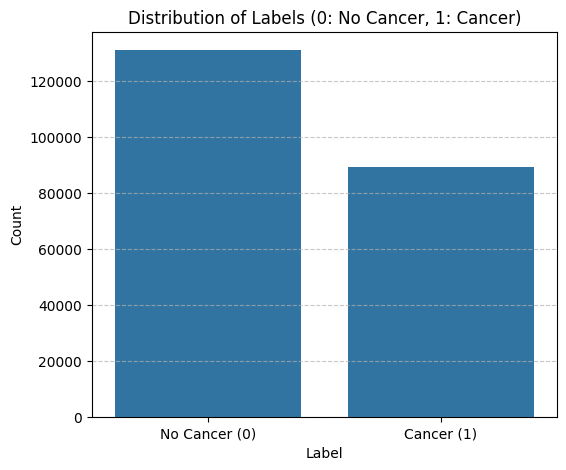


Total Samples: 220025
No Cancer Samples (0): 130908 (59.50%)
Cancer Samples (1): 89117 (40.50%)


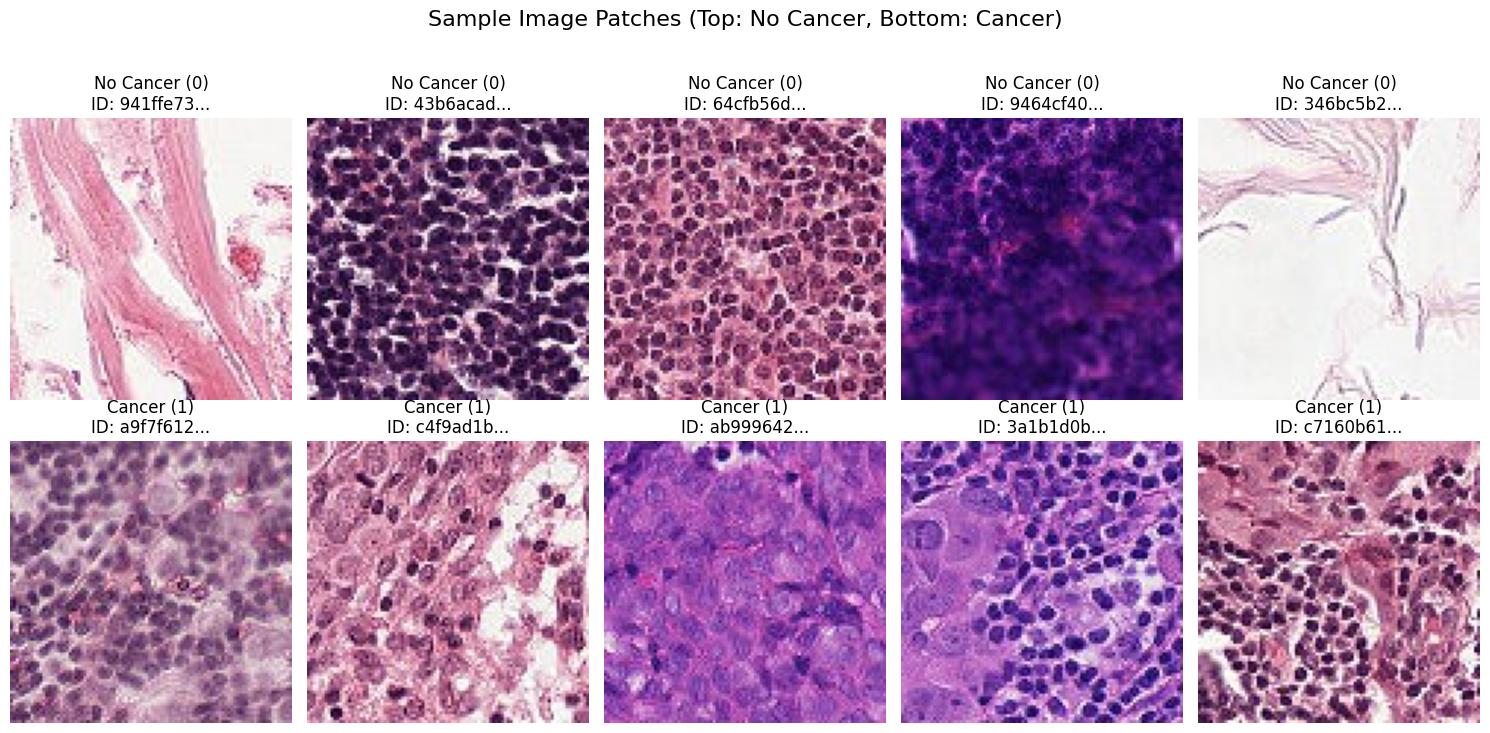

In [3]:
print("\nEDA: Data Info")
train_df.info()

print("\nEDA: Missing Values Check")
print(train_df.isnull().sum())

#Visualize Data
plt.figure(figsize=(6, 5))
sns.countplot(x='label', data=train_df)
plt.title('Distribution of Labels (0: No Cancer, 1: Cancer)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No Cancer (0)', 'Cancer (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Calculate and print class percentages
total_samples = len(train_df)
cancer_count = train_df['label'].sum()
no_cancer_count = total_samples - cancer_count
print(f"\nTotal Samples: {total_samples}")
print(f"No Cancer Samples (0): {no_cancer_count} ({no_cancer_count / total_samples:.2%})")
print(f"Cancer Samples (1): {cancer_count} ({cancer_count / total_samples:.2%})")

# Sample image display
sample_no_cancer_paths = train_df[train_df['label'] == 0]['path'].sample(5, random_state=42).tolist()
sample_cancer_paths = train_df[train_df['label'] == 1]['path'].sample(5, random_state=42).tolist()

plt.figure(figsize=(15, 8))
# No Cancer Samples
for i, img_path in enumerate(sample_no_cancer_paths):
    img = Image.open(img_path)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f"No Cancer (0)\nID: {os.path.basename(img_path).split('.')[0][:8]}...")
    plt.axis('off')

# Cancer Samples
for i, img_path in enumerate(sample_cancer_paths):
    img = Image.open(img_path)
    plt.subplot(2, 5, i + 6)
    plt.imshow(img)
    plt.title(f"Cancer (1)\nID: {os.path.basename(img_path).split('.')[0][:8]}...")
    plt.axis('off')

plt.suptitle('Sample Image Patches (Top: No Cancer, Bottom: Cancer)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**EDA Analysis:** Based on the EDA performed, there is an imbalance in the data. Currently, there is more samples of no cancer then there is cancer samples. During training, this will need to addressed in order to prevent the model from oversampling and becoming biased toward non-cancerous images.

**Data Cleaning and Preprocessing:** The image pixels will need to be normalized as a range from 0 to 1 by dividing by 255. This allows the neural network to learn more efficiently. To prevent overfitting and remove the class imbalance, the data will need to be randomly rotated, horizontally or vertically flipped, shifted by width and height, sheared, zoomed in and out, and adjust the brightness. Doing so will create diversity within the training data for the model to learn on. The class weights will also be balanced through calculations and be applied during training. Lastly, the training dataset will be split between training and validation sets in order to monitor the performance of the model on unseen data, and dictate wether the model is learning or memorizing, which leads to overfitting.

**Model Architecture:** A convolutional Neural Network is the best architecture for this project based on CNNs being able to capture hierachies and patterns in image datasets. With these images containing many different textures and structures of the cells, a CNN will be able to analyze the image efficiently. The model architecture consists of multiple convolutional blocks, with each having a Conv2D layer, an ReLU activation function, and a MaxPooling2D layerfor spatial dimension reduction. A Batch Normalization layer accelerates the training, and Dropout layers will prevent overfitting of the data. Flattening and Dense layers will convert the images to a 1D vector and classify each image. The use of a CNN architecture could be compared to another archtecture type such as transfer learning approach, as this type of archtecture is pre trained on medically related image datasets. The hyperparameters that will be tuned during training will include the learning rate, batch size, number of Epochs, Dropout Rate, and the number of filters in each convolutant layer.

In [4]:
# Split data into training and validation
train_df['label'] = train_df['label'].astype(str)
train_val_df, test_df_for_evaluation = train_test_split(
    train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

print(f"\nTrain-Validation Split: Train samples: {len(train_val_df)}, Validation samples: {len(test_df_for_evaluation)}")

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_val_df['label']),
    y=train_val_df['label'])
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Calculated Class Weights: {class_weights_dict}")

# Image Data Generators for augmentation and scaling
IMAGE_SIZE = (96, 96)
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2])

validation_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_val_df,
    x_col='path',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    seed=42)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=test_df_for_evaluation,
    x_col='path',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    seed=42)


# Model Building and Training
def build_custom_cnn_model(input_shape=(96, 96, 3)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')])

    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'auc']) 

    return model

tf.keras.backend.clear_session()
gc.collect()

# Build the model
model = build_custom_cnn_model()
model.summary()

# Define Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Save the best model based on validation AUC
checkpoint_filepath = 'best_model.keras'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose=1)

# Train the model
EPOCHS = 50 
print("\n--- Starting Model Training ---")
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    class_weight=class_weights_dict,
    callbacks=[reduce_lr, early_stopping, model_checkpoint],
    verbose=1)

print("--- Model Training Complete ---")
# Load the best model saved by ModelCheckpoint
from tensorflow.keras.models import load_model
best_model = load_model(checkpoint_filepath)
print(f"\nLoaded best model from: {checkpoint_filepath}")

# Model loading and evaluation
if os.path.exists(checkpoint_filepath):
    from tensorflow.keras.models import load_model
    best_model = load_model(checkpoint_filepath)
    print(f"\nLoaded best model from: {checkpoint_filepath}")


Train-Validation Split: Train samples: 176020, Validation samples: 44005
Calculated Class Weights: {0: 0.8403834768825316, 1: 1.2344657334418043}
Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


/Users/jackperrin/miniconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-22 16:48:51.881674: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-06-22 16:48:51.881832: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-06-22 16:48:51.881848: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-06-22 16:48:51.882366: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-22 16:48:51.882375: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_fac

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,814,273 (18.36 MB)

 Trainable params: 4,813,313 (18.36 MB)

 Non-trainable params: 960 (3.75 KB)


--- Starting Model Training ---
Epoch 1/50


/Users/jackperrin/miniconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-06-22 16:48:52.695734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


11001/11001 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7427 - auc: 0.8162 - loss: 0.5678
Epoch 1: val_auc improved from -inf to 0.89287, saving model to best_model.keras
11001/11001 ━━━━━━━━━━━━━━━━━━━━ 361s 33ms/step - accuracy: 0.7427 - auc: 0.8162 - loss: 0.5678 - val_accuracy: 0.8125 - val_auc: 0.8929 - val_loss: 0.4193 - learning_rate: 1.0000e-04
Epoch 2/50
    1/11001 ━━━━━━━━━━━━━━━━━━━━ 9:02 49ms/step - accuracy: 0.6875 - auc: 0.8000 - loss: 0.4886

/Users/jackperrin/miniconda3/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_auc improved from 0.89287 to 0.89379, saving model to best_model.keras
11001/11001 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.6875 - auc: 0.8000 - loss: 0.4886 - val_accuracy: 0.8149 - val_auc: 0.8938 - val_loss: 0.4153 - learning_rate: 1.0000e-04
Epoch 3/50
11000/11001 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8149 - auc: 0.8852 - loss: 0.4284
Epoch 3: val_auc improved from 0.89379 to 0.90010, saving model to best_model.keras
11001/11001 ━━━━━━━━━━━━━━━━━━━━ 358s 33ms/step - accuracy: 0.8149 - auc: 0.8852 - loss: 0.4284 - val_accuracy: 0.8216 - val_auc: 0.9001 - val_loss: 0.3936 - learning_rate: 1.0000e-04
Epoch 4/50
    1/11001 ━━━━━━━━━━━━━━━━━━━━ 7:24 40ms/step - accuracy: 0.6875 - auc: 0.8095 - loss: 0.4928
Epoch 4: val_auc did not improve from 0.90010
11001/11001 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.6875 - auc: 0.8095 - loss: 0.4928 - val_accuracy: 0.8214 - val_auc: 0.8985 - val_loss: 0.3959 - learning_rate: 1.0000e-04
Epoch 5/50
11000/11001 ━━

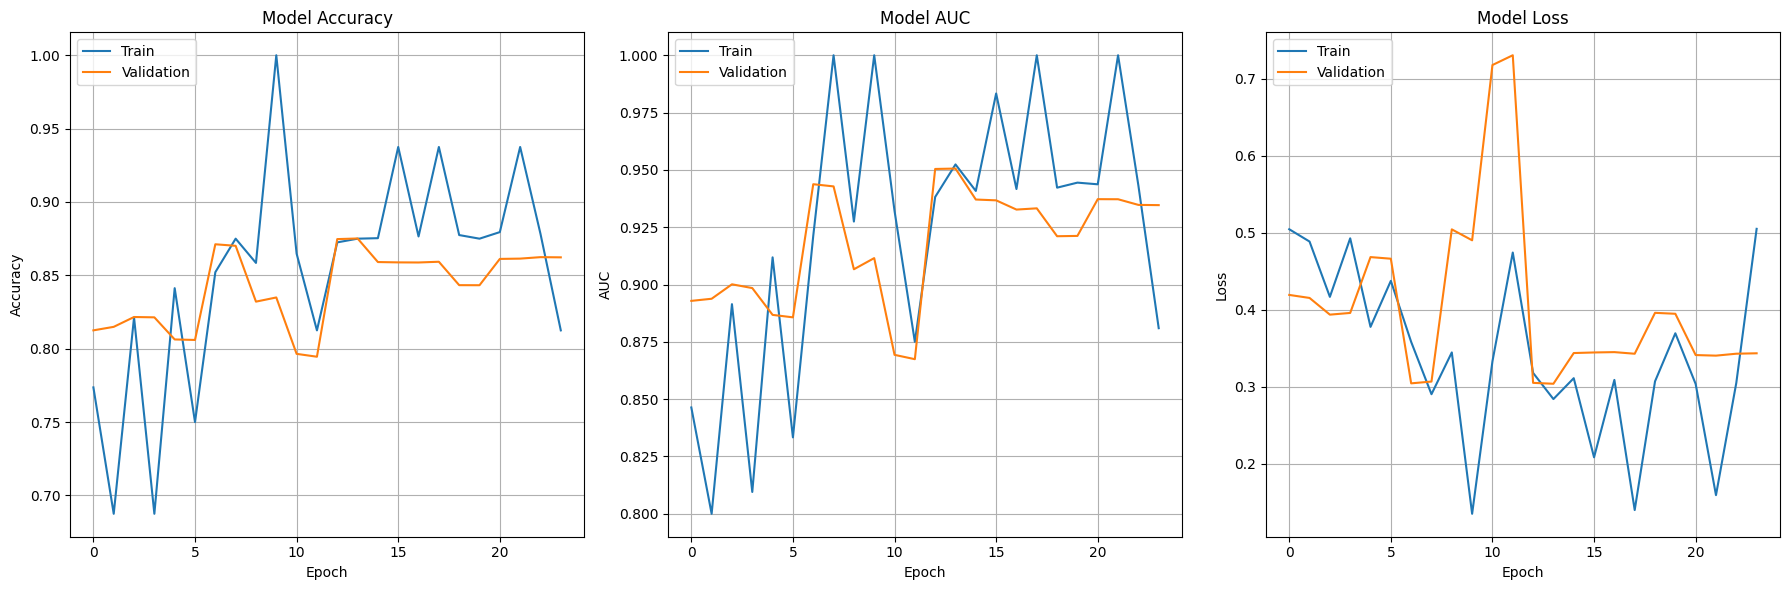


--- Evaluating Best Model on Validation Set ---
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - accuracy: 0.8741 - auc: 0.9494 - loss: 0.3094

Validation Loss: 0.3038
Validation Accuracy: 0.8751
Validation AUC: 0.9506
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step

--- Classification Report (Validation Set) ---
              precision    recall  f1-score   support

           0       0.59      0.68      0.64     26182
           1       0.40      0.31      0.35     17823

    accuracy                           0.53     44005
   macro avg       0.50      0.50      0.49     44005
weighted avg       0.52      0.53      0.52     44005



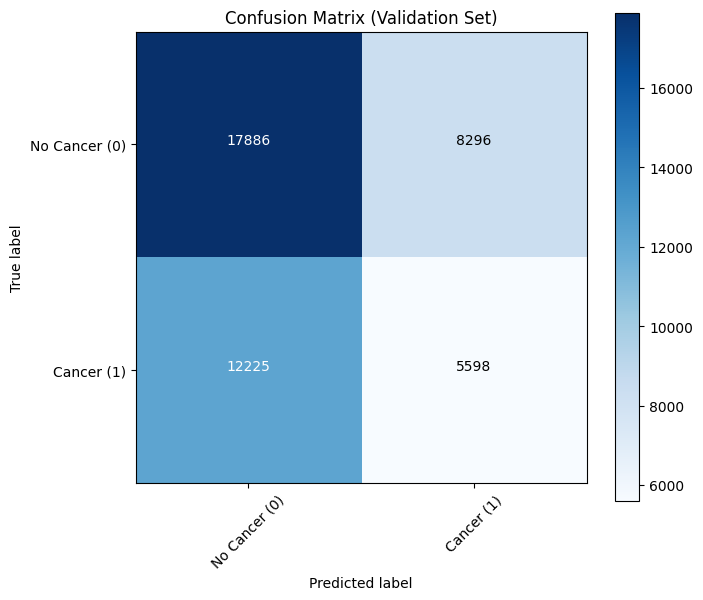

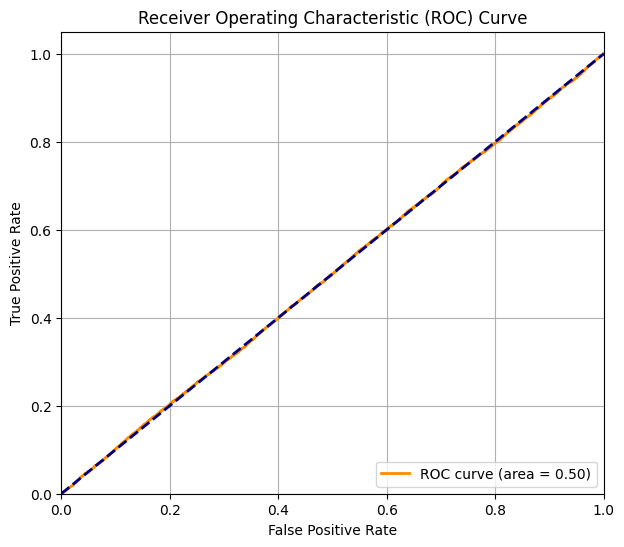

In [5]:
plt.figure(figsize=(18, 6))

# Plot training & validation accuracy values
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)

# Plot training & validation AUC values
plt.subplot(1, 3, 2)
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 3, 3)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

print("\n--- Evaluating Best Model on Validation Set ---")
val_loss, val_accuracy, val_auc = best_model.evaluate(validation_generator, verbose=1)

print(f"\nValidation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation AUC: {val_auc:.4f}")

validation_generator.reset()
val_probabilities = best_model.predict(validation_generator)
val_predictions = (val_probabilities > 0.5).astype(int)
val_true_labels = test_df_for_evaluation['label'].astype(int).values

# Classification Report
print("\n--- Classification Report (Validation Set) ---")
print(classification_report(val_true_labels, val_predictions))

# Confusion Matrix
cm = confusion_matrix(val_true_labels, val_predictions)

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(7, 6))
plot_confusion_matrix(cm, classes=['No Cancer (0)', 'Cancer (1)'],
                      title='Confusion Matrix (Validation Set)')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(val_true_labels, val_probabilities)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

**Results and Analysis Discussion:** Based on the results of the model training, the model was overall successful at determining non-cancerous from cancerous tissues images. However, the model had a higher accuracy rate for non-cancerous images than for cancerous images. This is seen in the report by the low recall (0.31) for the cancer class images. The high AUC score (0.95) depicts that the model can differentiate the samples into positive and negative. Yet, in order to improve the model overall, the recall for class 1 (cancerous images) would need to be improved by raising the default threshold from 0.5.

**Conclusion:** From the results and overall performance, the model is sufficiently able to differentiate a cancerous from a non-cancerous tissue, but with fine-tuning, the performance could be improved. The high AUC score depicts that the model was able to differentiate well, but by improving the classification threshold, the model would be able to convert the probabilities into binary classifications. In addition, the class imbalance between cancerous and non-cancerous images could be reevaluated. Even when using class_weight='balanced', the recall for class 1 (cancerous) is low. By oversampling the minority class using the imblearn libraries or using a more aggressive ImageDataGenerator, the positive class could have a higher recall score. In addition, utilizing a focal loss function could be effective for the imbalanced dataset by reducing the weight of more easily identifiable examples in the training data, putting more focus on difficult training data. Furthermore, another improvement that could be made to the model would be using a transfer learning method of a CNN architecture. The pre-trained transfer learning architecture for medically related images may improve the overall precision of the training of the model, which in turn creates a more accurate model for unseen data in future use.

In [6]:
print("\n--- Generating Kaggle Submission File ---")

test_image_ids = [f.split('.')[0] for f in os.listdir(TEST_DIR) if f.endswith('.tif')]
test_df = pd.DataFrame({'id': test_image_ids})
test_df['path'] = test_df['id'].apply(lambda x: os.path.join(TEST_DIR, f'{x}.tif'))

# Sort by ID for consistent order
test_df = test_df.sort_values(by='id').reset_index(drop=True)

print(f"Test DataFrame loaded. Shape: {test_df.shape}")
print(test_df.head())

#Create test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col=None, # No labels for test set
    target_size=IMAGE_SIZE,
    class_mode=None, # No class mode, as we are only predicting
    batch_size=BATCH_SIZE,
    shuffle=False, # Important: Do not shuffle test data to maintain order
    seed=42)

# Check if the best_model was successfully loaded
if 'best_model' in locals() and best_model is not None:
    print(f"\nMaking predictions on {len(test_df)} test images...")
    test_probabilities = best_model.predict(test_generator, verbose=1)

    # Convert probabilities to binary labels (0 or 1)
    prediction_threshold = 0.5
    test_predictions = (test_probabilities > prediction_threshold).astype(int)

    # Flatten the predictions array to a 1D array
    test_predictions = test_predictions.flatten()

    # Create Submission DataFrame
    submission_df = pd.DataFrame({
        'id': test_df['id'],
        'label': test_predictions})

    # Save to CSV
    submission_filename = 'submission.csv'
    submission_df.to_csv(submission_filename, index=False)

    print(f"\nSubmission file '{submission_filename}' created successfully!")
    print(submission_df.head())
    print(f"Submission file saved with shape: {submission_df.shape}")
    print(f"Count of predicted 'cancer' (1) labels: {submission_df['label'].sum()}")
    print(f"Count of predicted 'no cancer' (0) labels: {len(submission_df) - submission_df['label'].sum()}")

else:
    print("\nWARNING: Best model not loaded. Cannot generate submission file.")
    print("Please resolve the model loading issue (see messages above) before attempting to create a submission.")


--- Generating Kaggle Submission File ---
Test DataFrame loaded. Shape: (57458, 2)
                                         id  \
0  00006537328c33e284c973d7b39d340809f7271b   
1  0000ec92553fda4ce39889f9226ace43cae3364e   
2  00024a6dee61f12f7856b0fc6be20bc7a48ba3d2   
3  000253dfaa0be9d0d100283b22284ab2f6b643f6   
4  000270442cc15af719583a8172c87cd2bd9c7746   

                                                path  
0  /Users/jackperrin/Downloads/Histopathologic_Ca...  
1  /Users/jackperrin/Downloads/Histopathologic_Ca...  
2  /Users/jackperrin/Downloads/Histopathologic_Ca...  
3  /Users/jackperrin/Downloads/Histopathologic_Ca...  
4  /Users/jackperrin/Downloads/Histopathologic_Ca...  
Found 57458 validated image filenames.

Making predictions on 57458 test images...
  10/3592 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step   

/Users/jackperrin/miniconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3592/3592 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step

Submission file 'submission.csv' created successfully!
                                         id  label
0  00006537328c33e284c973d7b39d340809f7271b      1
1  0000ec92553fda4ce39889f9226ace43cae3364e      1
2  00024a6dee61f12f7856b0fc6be20bc7a48ba3d2      1
3  000253dfaa0be9d0d100283b22284ab2f6b643f6      1
4  000270442cc15af719583a8172c87cd2bd9c7746      0
Submission file saved with shape: (57458, 2)
Count of predicted 'cancer' (1) labels: 15218
Count of predicted 'no cancer' (0) labels: 42240
